# Merging GP sub-models

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))

noise_var = 0.01

def plot_mean_conf(x, mean, var, ax, color='C0'):
        ax.plot(x, mean, color, lw=2)
        ax.fill_between(
            x[:, 0],
            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
            color=color,
            alpha=0.2,
        )
    
def plot_model(m, ax, x=np.linspace(0, 1, 101)[:, None], plot_data=True, color='C0'):
    if plot_data:
        X, Y = m.data
        ax.plot(X, Y, "kx", mew=1.)
    
    mean, var = m.predict_f(x)[:2]
    plot_mean_conf(x, mean, var, ax, color)


2022-04-06 11:38:03.791184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 11:38:03.791214: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/tmp/ipykernel_24820/469818386.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


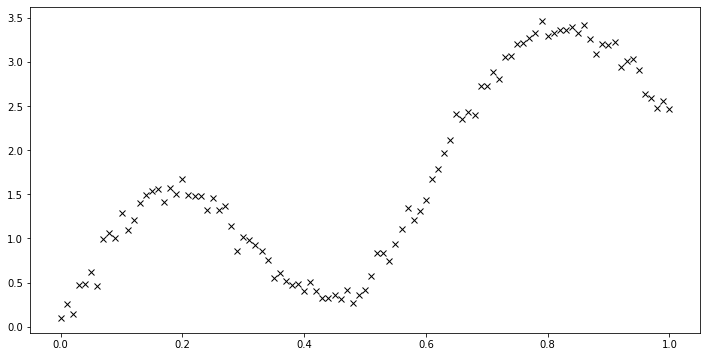

In [2]:
def f(x):
    return np.sin(10 * x[:, :1]) + 3. * x[:, :1]

X = np.linspace(0, 1, 101)[:, None]
#np.random.shuffle(X)
Y = f(X) + np.sqrt(noise_var) * np.random.normal(size=X.shape)

plt.plot(X, Y, 'kx')

### train some submodels

2022-04-06 11:38:06.077971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-06 11:38:06.077999: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 11:38:06.078012: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nicolas-lptp): /proc/driver/nvidia/version does not exist
2022-04-06 11:38:06.078348: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


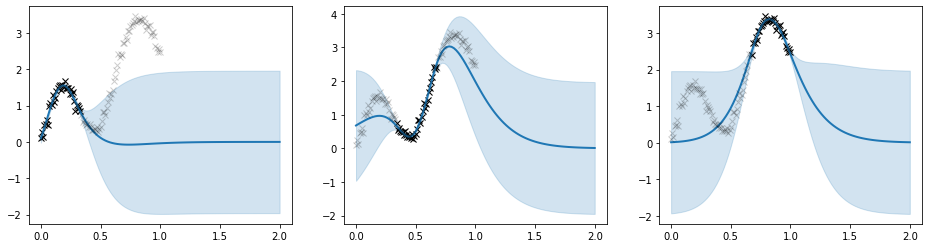

In [3]:
num_split = 3
Xs = np.array_split(X, num_split)
Ys = np.array_split(Y, num_split)

# define a kernel
k = gpflow.kernels.Matern52(1., .3)

# build a list of submodels
M = [gpflow.models.GPR(data=(xs, ys), kernel=k) for (xs, ys) in zip(Xs, Ys)]

# set noise variance to a reasonable value
[m.likelihood.variance.assign(noise_var) for m in M]

# plot predictions
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
[plot_model(m, axes[i], x = np.linspace(0, 2, 101)[:, None]) for i, m in enumerate(M)];
[axes[i].plot(X, Y, 'kx', mew=1., alpha=.2) for i, _ in enumerate(M)];

Look at what what is happening at a given $x=0.5$

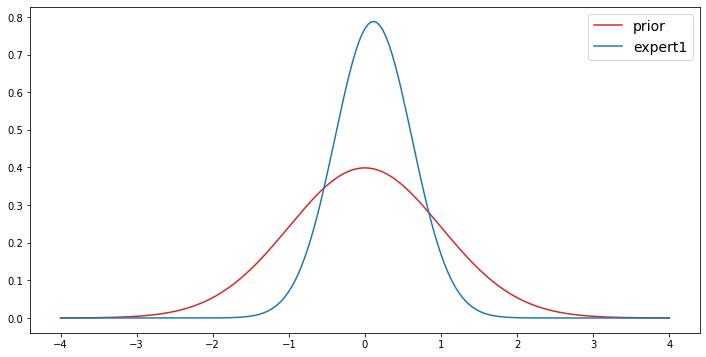

In [4]:
yy = np.linspace(-4, 4, 201)

mp, vp = 0., k.variance
prior_pdf = norm.pdf(yy, mp, np.sqrt(vp))

me1, ve1 = M[0].predict_f(np.array([[0.5]]))
me1, ve1 = me1.numpy().flatten(), ve1.numpy().flatten()
expert1_pdf = norm.pdf(yy, me1 , np.sqrt(ve1))

plt.plot(yy, prior_pdf, 'C3', label='prior')
plt.plot(yy, expert1_pdf, label='expert1')

plt.legend(fontsize=14)

At this specific location, we define a "pseudo-likelihood" that corresponds to a pseudo-observation that would explain the expert posterior:

$$ posterior \propto prior \times pseudo\_likelihood$$

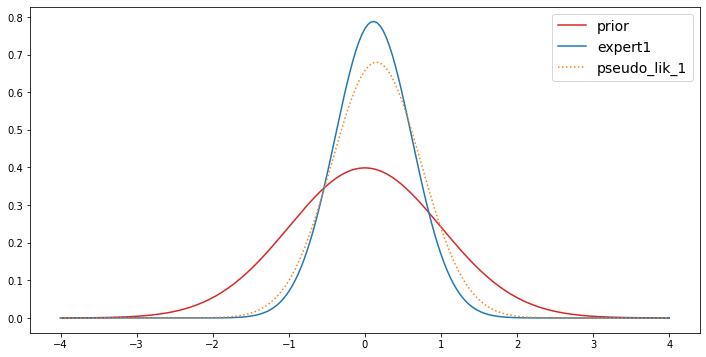

In [5]:
mpl1 = mp + vp / (vp - ve1) * (me1 - mp)
vpl1 = vp * ve1 / (vp - ve1)
pl1_pdf = norm.pdf(yy, mpl1 , np.sqrt(vpl1))

plt.plot(yy, prior_pdf, 'C3', label='prior')
plt.plot(yy, expert1_pdf, label='expert1')
plt.plot(yy, pl1_pdf, 'C1:', label='pseudo_lik_1')

plt.legend(fontsize=14)

We can now do this for all three experts

(0.0, 2.0)

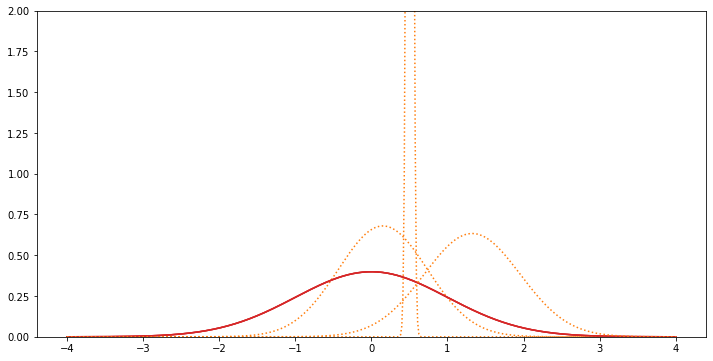

In [6]:
yy = np.linspace(-4, 4, 501)

MPL, VPL = np.zeros(4) + mp, np.zeros(4) + vp.numpy()

for i in range(3):
    prior_pdf = norm.pdf(yy, mp, np.sqrt(vp))

    me1, ve1 = M[i].predict_f(np.array([[0.5]]))
    me1, ve1 = me1.numpy().flatten(), ve1.numpy().flatten()
    expert1_pdf = norm.pdf(yy, me1 , np.sqrt(ve1))

    mpl1 = mp + vp / (vp - ve1) * (me1 - mp)
    vpl1 = vp * ve1 / (vp - ve1)
    MPL[i+1] = mpl1
    VPL[i+1] = vpl1
    pl1_pdf = norm.pdf(yy, mpl1 , np.sqrt(vpl1))

    plt.plot(yy, prior_pdf, 'C3', label='prior')
    #plt.plot(yy, expert1_pdf, 'C0', label='expert1')
    plt.plot(yy, pl1_pdf, 'C1:', label='pseudo_lik_1')

plt.ylim((0, 2))

In order to compute the posterior, we multiply the prior with the 3 pseudo-likelihoods

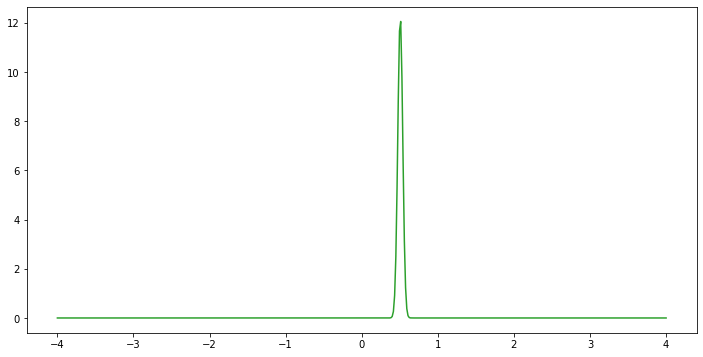

In [7]:
post_var = 1 / (np.sum(1 / VPL))
post_mean = post_var * np.sum(MPL / VPL)

post_pdf = norm.pdf(yy, post_mean , np.sqrt(post_var))
plt.plot(yy, post_pdf, 'C2', label='pseudo_lik_1')

### Merge submodels: Same thing but for all $x$ at once!

In [8]:
class merge_latents():
    
    def __init__(self, model_list):
        #TODO assert that all submodels priors are the same
        self.model_list = model_list
        
    def predict_f(self, x):
        # prior distribution
        mp = self.model_list[0].mean_function(x)
        vp = self.model_list[0].kernel.K_diag(x)[:, None]
        
        # expert distributions
        preds = [m.predict_f(x) for m in self.model_list]
        Me = tf.concat([pred[0] for pred in preds], axis=1)
        Ve = tf.concat([pred[1] for pred in preds], axis=1) 

        # equivalent pseudo observations that would turn
        # the prior at x into the expert posterior at x
        pseudo_noise = vp * Ve / (vp - Ve)
        pseudo_y = mp + vp / (vp - Ve) * (Me - mp)

        # prediction 
        var = 1 / (1 / vp + tf.reduce_sum(1 / pseudo_noise, axis=1, keepdims=True))
        mean = var * (mp / vp + tf.reduce_sum(pseudo_y / pseudo_noise, axis=1, keepdims=True))

        return mean, var, pseudo_y, pseudo_noise

First, let's look at the pseudo-observations

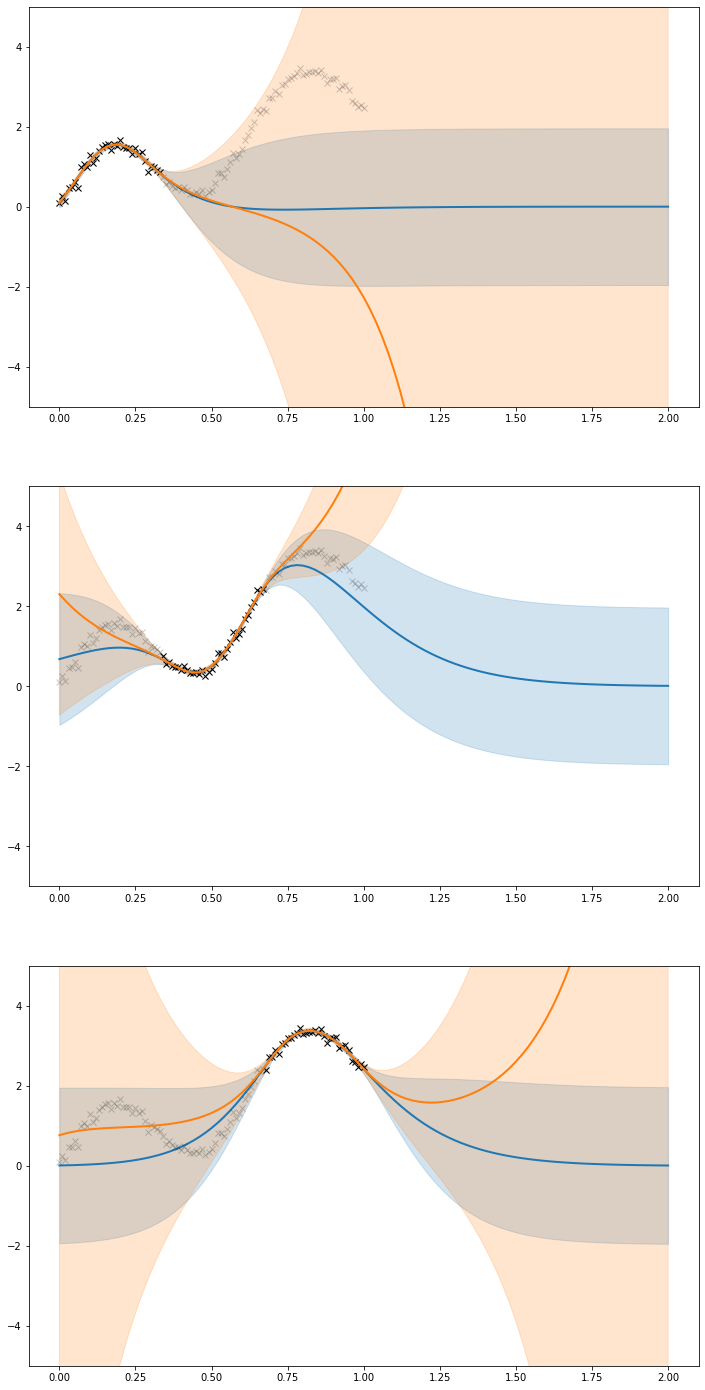

In [9]:
x = np.linspace(0, 2, 101)[:, None]
m_agg = merge_latents(M)
m, v, p_y, p_n = m_agg.predict_f(x)

# plot pseudo-obs
fig, axes = plt.subplots(3, 1, figsize=(12, 25))
for i, m in enumerate(M):
    plot_model(m, axes[i], x)
    axes[i].plot(X, Y, 'kx', mew=1., alpha=.2)
    plot_mean_conf(x, p_y[:, i:i+1], p_n[:, i:i+1], axes[i], 'C1')
    axes[i].set_ylim((-5, 5))


We can now merge the 3 models by multiplying the prior and all the pseudo-likelihood together (linear cost!).

(-5.0, 5.0)

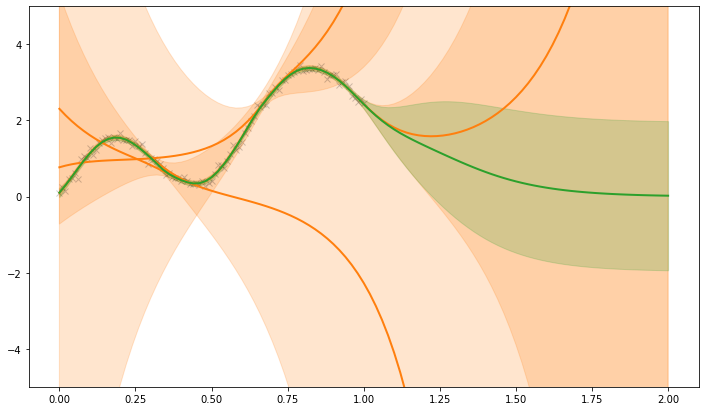

In [10]:
# plot predictions
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(X, Y, 'kx', mew=1., alpha=.2)
    
for i, m in enumerate(M):
    plot_mean_conf(x, p_y[:, i:i+1], p_n[:, i:i+1], ax, 'C1')

plot_model(m_agg, ax, x, plot_data=False, color='C2')
ax.set_ylim((-5, 5))

The aggregated model can be compared with the true posterior

(-0.5, 4.0)

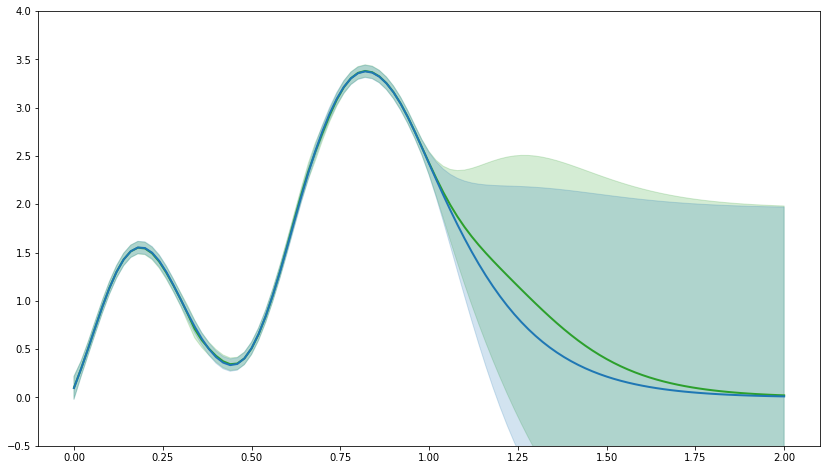

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
plot_model(m_agg, ax, x, plot_data=False, color='C2')

m_full = gpflow.models.GPR(data=(X, Y), kernel=k)
m_full.likelihood.variance.assign(noise_var)
plot_model(m_full, ax, x = np.linspace(0, 2, 101)[:, None], plot_data=False)

ax.set_ylim((-.5, 4))

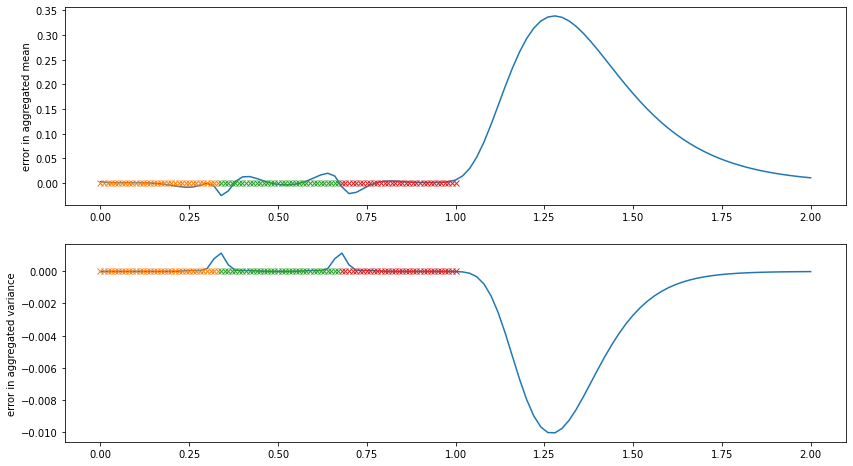

In [12]:
x = np.linspace(0, 2, 101)[:, None]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# plot errors of mean function
axes[0].plot(x, m_agg.predict_f(x)[0] - m_full.predict_f(x)[0])
axes[0].set_ylabel('error in aggregated mean')
for xx in Xs:
    axes[0].plot(xx, 0 * xx, 'x')

# plot errors in variance prediction
axes[1].plot(x, m_agg.predict_f(x)[1] - m_full.predict_f(x)[1])
axes[1].set_ylabel('error in aggregated variance')
for xx in Xs:
    axes[1].plot(xx, 0 * xx, 'x')
    

## Beyond marginal prediction: multivariate posterior

The previous model merging is done independently for all input locations, which does not allow us to compute a posterior joint distribution.

Alternatively, one can consider multivariate expert posteriors and a multivariate pseudo-likelihood:

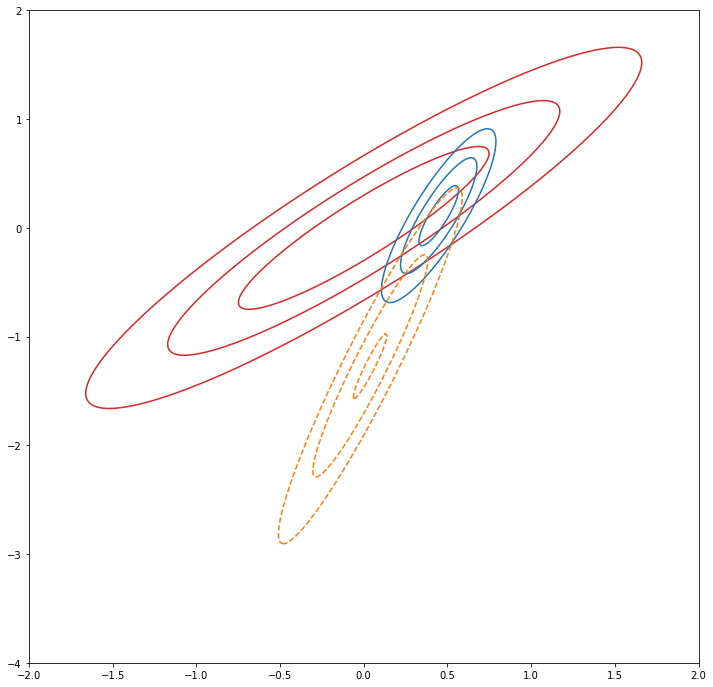

In [13]:
Xt = np.array([[0.4, 0.5]]).T

def plt_mvn(mu, Sigma, color='C0', linestyles='solid'):

    x, y = np.meshgrid(np.linspace(-2,2,300),np.linspace(-4,2,300))
    xy = np.column_stack([x.flat, y.flat])

    # density values at the grid points
    Z = mvn.pdf(xy, mu.flatten(), Sigma).reshape(x.shape)

    # arbitrary contour levels
    fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles)
    
mup, Sp = np.zeros((2, 1)), k.K(Xt).numpy()

me1, Se1 = M[0].predict_f(Xt, full_cov=True)
me1, Se1 = me1.numpy(), Se1.numpy()[0]

#Spl1 = np.linalg.inv(np.linalg.inv(Sp) + np.linalg.inv(Se1))
#mpl1 = Spl1 @ (np.linalg.inv(Sp) @ mup + np.linalg.inv(Se1) @ me1)

jitter = 1e-8 * np.eye(2)
Spl1 = Sp @ np.linalg.inv(Sp - Se1 + jitter) @ Sp - Sp
mpl1 = mup + Sp @ np.linalg.inv(Sp - Se1 + jitter) @ (me1 - mup)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt_mvn(mup, Sp, 'C3')
plt_mvn(me1, Se1, 'C0')
plt_mvn(mpl1, Spl1, 'C1', linestyles='dashed')

In [14]:
class merge_latents():
    
    def __init__(self, model_list):
        #TODO assert that all submodels priors are the same
        self.model_list = model_list
        
    def predict_f(self, x):
        # prior distribution
        mp = self.model_list[0].mean_function(x)
        vp = self.model_list[0].kernel.K_diag(x)[:, None]
        
        # expert distributions
        preds = [m.predict_f(x) for m in self.model_list]
        Me = tf.concat([pred[0] for pred in preds], axis=1)
        Ve = tf.concat([pred[1] for pred in preds], axis=1) 

        # equivalent pseudo observations that would turn
        # the prior at x into the expert posterior at x
        pseudo_noise = vp * Ve / (vp - Ve)
        pseudo_y = mp + vp / (vp - Ve) * (Me - mp)

        # prediction 
        var = 1 / (1 / vp + tf.reduce_sum(1 / pseudo_noise, axis=1, keepdims=True))
        mean = var * (mp / vp + tf.reduce_sum(pseudo_y / pseudo_noise, axis=1, keepdims=True))

        return mean, var, pseudo_y, pseudo_noise

    def _get_expert_pred(self, x):
       
        # expert distributions
        preds = [m.predict_f(x, full_cov=True) for m in self.model_list]
        Me = tf.concat([pred[0][None, :, :] for pred in preds], axis=0)
        Ve = tf.concat([pred[1] for pred in preds], axis=0) 

        return Me, Ve
    
    
    def predict_f_full(self, x):
        k = len(self.model_list)
        
        # prior distribution
        mp = self.model_list[0].mean_function(x)
        vp = self.model_list[0].kernel.K(x)[None, :, :]
        mp = tf.tile(tf.transpose(mp), [k, 1])[:, :, None]
        vp = tf.tile(vp, [k, 1, 1])
        
        # expert distributions
        Me, Ve = self._get_expert_pred(x)

        # equivalent pseudo observations that would turn
        # the prior at x into the expert posterior at x 
        #
        jitter = 1e-8 * np.eye(x.shape[0])
        pseudo_noise = vp @ tf.linalg.inv(vp - Ve + jitter) @ vp - vp
        #pseudo_noise = vp @ tf.linalg.inv(vp - Ve ) @ Ve
        #pseudo_noise = tf.linalg.inv(tf.linalg.inv(vp) - tf.linalg.inv(Ve))
        pseudo_y = mp + vp @ tf.linalg.inv(vp - Ve + jitter) @ (Me - mp)
        #pseudo_y = mp + pseudo_noise @ tf.linalg.inv(Ve) @ (Me - mp)
        
        #print(np.max(np.abs(pseudo_noise - pseudo_noise_old)))
        # prediction 
        var = tf.linalg.inv(tf.linalg.inv(vp[0, :, :]) + tf.reduce_sum(tf.linalg.inv(pseudo_noise), axis=0))
        mean = var @ (tf.linalg.inv(vp[0, :, :]) @ mp[0, :, :] + tf.reduce_sum(tf.linalg.inv(pseudo_noise) @ pseudo_y, axis=0))
        return mean, var, pseudo_y, pseudo_noise

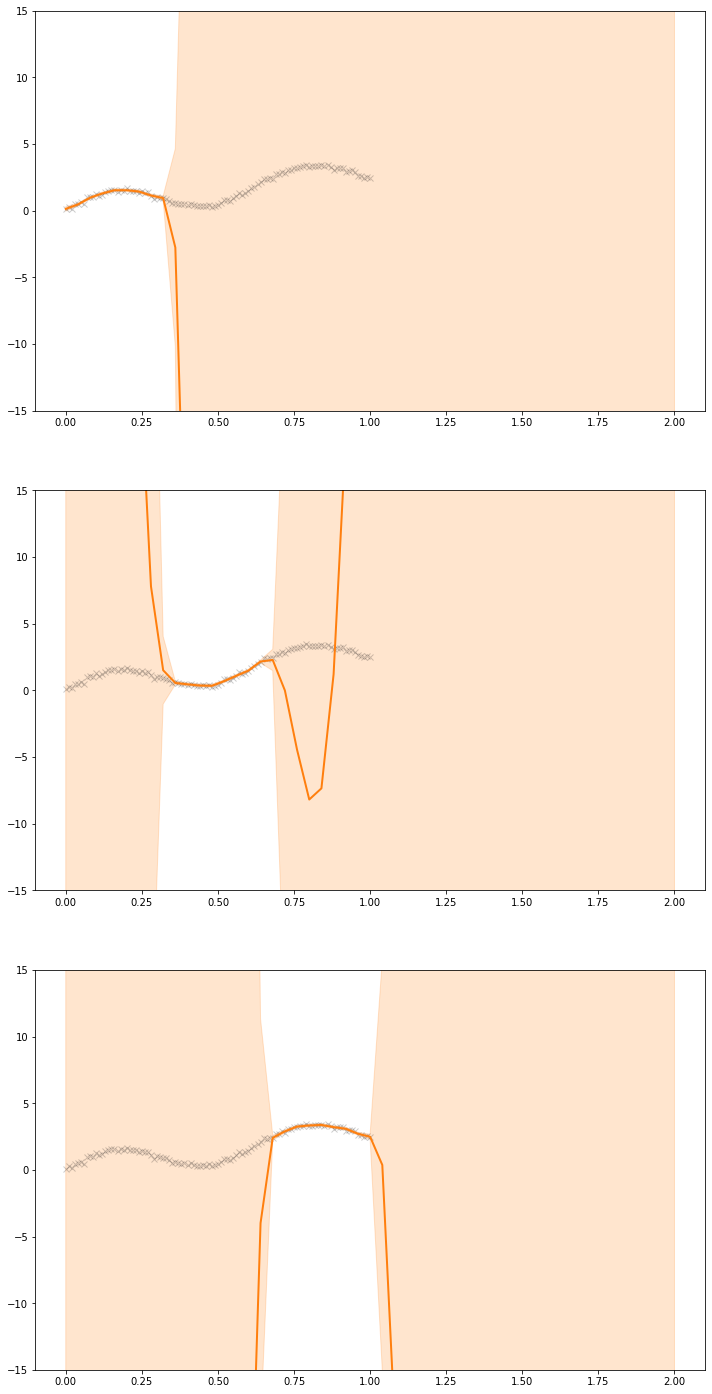

In [15]:
x = np.linspace(0, 2, 51)[:, None]
m_agg = merge_latents(M)
m, v, p_y, p_n = m_agg.predict_f_full(x)
v = tf.linalg.diag_part(v)[:, None]

p_y = tf.transpose(p_y,(1, 0, 2))[:, :, 0]
p_n = tf.transpose(tf.linalg.diag_part(p_n))
#m = tf.transpose(m_agg.predict_f(x)[0],(1, 0, 2))[:, :, 0]
#v = tf.transpose(tf.linalg.diag_part(m_agg.predict_f(x)[1]))

# plot pseudo-obs
fig, axes = plt.subplots(3, 1, figsize=(12, 25))
for i, _ in enumerate(M):
    #plot_model(m, axes[i], x)
    axes[i].plot(X, Y, 'kx', mew=1., alpha=.2)
    plot_mean_conf(x, p_y[:, i:i+1], p_n[:, i:i+1], axes[i], 'C1')
    axes[i].set_ylim((-15, 15))

(-0.5, 4.0)

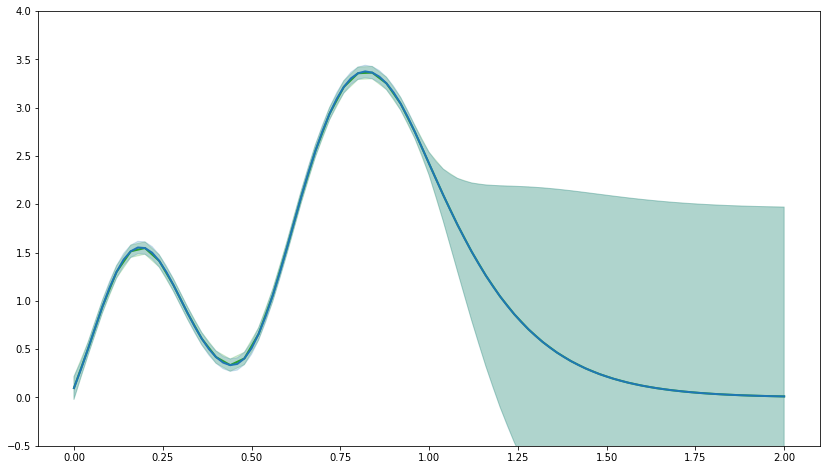

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
plot_mean_conf(x, m, v, ax, 'C2')

m_full = gpflow.models.GPR(data=(X, Y), kernel=k)
m_full.likelihood.variance.assign(noise_var)
plot_model(m_full, ax, x = np.linspace(0, 2, 101)[:, None], plot_data=False)

ax.set_ylim((-.5, 4))

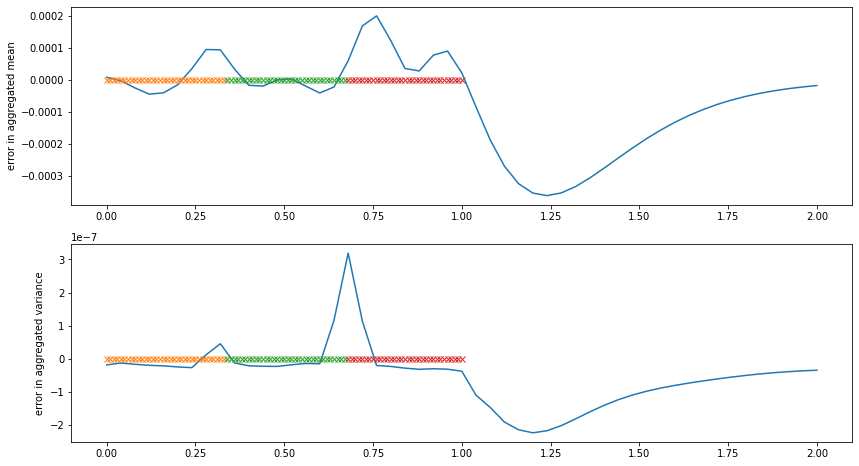

In [17]:
x = np.linspace(0, 2, 51)[:, None]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# plot errors of mean function
axes[0].plot(x, m - m_full.predict_f(x)[0])
axes[0].set_ylabel('error in aggregated mean')
for xx in Xs:
    axes[0].plot(xx, 0 * xx, 'x')

# plot errors in variance prediction
axes[1].plot(x, v - m_full.predict_f(x)[1])
axes[1].set_ylabel('error in aggregated variance')
for xx in Xs:
    axes[1].plot(xx, 0 * xx, 'x')


## Sample from aggregated posterior

In [18]:
x = np.linspace(0, 2, 51)[:, None]
m_agg = merge_latents(M)
m, v, p_y, p_n = m_agg.predict_f_full(x)

F = np.random.multivariate_normal(m[:, 0], v, 10).T

/tmp/ipykernel_24820/3047749888.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  F = np.random.multivariate_normal(m[:, 0], v, 10).T


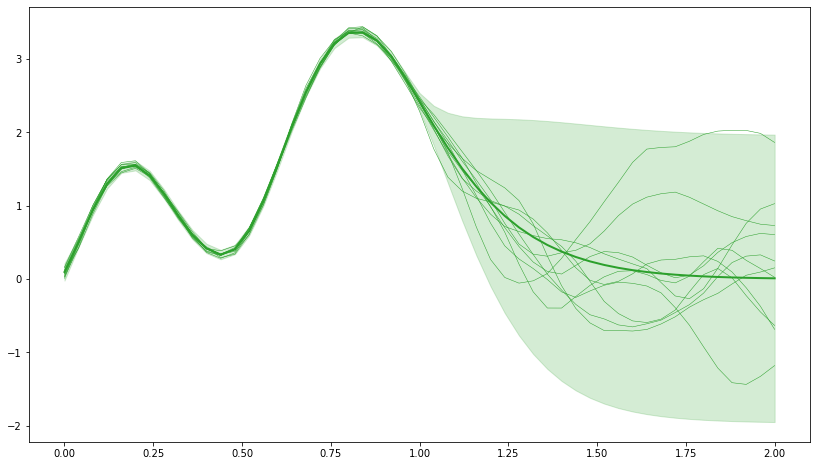

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
plot_mean_conf(x, m, tf.linalg.diag_part(v)[:, None], ax, 'C2')
plt.plot(x, F, 'C2', lw=.5);

Same thing but using the Matheron procedure to get continuous samples

In [20]:
import gpflux
from gpflux.layers.basis_functions.fourier_features import RandomFourierFeaturesCosine

tf.keras.backend.set_floatx('float64')

class Sample:
    def __init__(self, kernel, noise_variance=0., num_rff=1000):
        self.features = RandomFourierFeaturesCosine(kernel, n_components=num_rff)
        self.random_weight = np.random.normal(0, 1, (num_rff, 1))
        self.noise_variance = noise_variance
        
    def signal(self, x):
        signal = self.features(x) @ self.random_weight
        return signal
    
    def __call__(self, x):
        noise = np.sqrt(self.noise_variance) * np.random.normal(0, 1, (x.shape[0], 1))
        return  self.signal(x) + noise


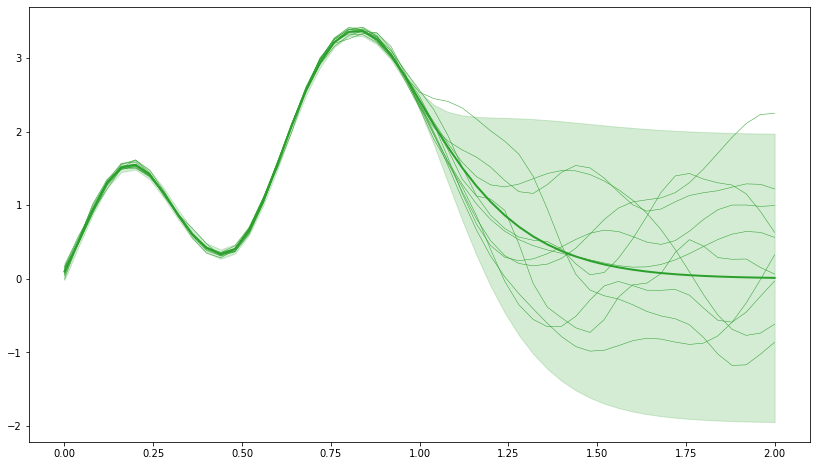

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

m_agg = merge_latents(M)
m, v, p_y, p_n = m_agg.predict_f_full(x)
plot_mean_conf(x, m, tf.linalg.diag_part(v)[:, None], ax, 'C2')

for i in range(10):
    x = np.linspace(0, 2, 51)[:, None]
    f = Sample(k)
    E = Y - f(X) + np.sqrt(noise_var) * np.random.normal(size=Y.shape)
    Es = np.array_split(E, num_split)

    # build a list of submodels of the error
    Me = [gpflow.models.GPR(data=(xs, es), kernel=k) for (xs, es) in zip(Xs, Es)]
    [m.likelihood.variance.assign(noise_var) for m in Me]

    # aggregate predictions
    m_agg = merge_latents(Me)
    m, v, p_y, p_n = m_agg.predict_f_full(x)
    ax.plot(x, f(x) + m, 'C2', lw=.5)


## Potential use cases and benefits of the approach

- Models that interpolate large datasets
- Good initialisation of SVGP models
- SVGP models with lots of inducing points (structured parametrisation of inducing variables)
- Cheap model updates for computing some acquisision functions in BO

